<a href="https://colab.research.google.com/github/ChiragAhir016/DS-670-Capstone-Project-Smart-City-Safety-Management/blob/main/Capstone_Week_2_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMS AI-DRIVEN NOTIFICATION SYSTEM

### Loading the dataset

In [4]:
# REQUIRED LIBRARIES

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## ML sampling, models and data splitting
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from imblearn.over_sampling import RandomOverSampler



In [134]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfTransformer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [135]:
import numpy as np
# Load your dataset
file_path = 'NYCEM_Emergency_Notifications_20231217.csv'
df = pd.read_csv(file_path)

## showcasing the data header
df.head()
# df['NotificationType'].unique()

,Record ID,Date and Time,NotificationType,Notification Title,Email Body
0,209,05/11/2009 10:00:00 AM,zINAC * Aerial (Fly-Over),[blank],This is a message from Notify NYC. Notificatio...
1,210,05/15/2009 08:00:00 AM,zINAC * Drills / Exercises,[blank],This is a message from Notify NYC. Notificatio...
2,211,05/16/2009 05:00:00 PM,zINAC * Drills / Exercises,[blank],This is a message from Notify NYC. Notificatio...
3,212,05/17/2009 05:00:00 PM,zINAC * Drills / Exercises,[blank],This is a message from Notify NYC. Notificatio...
4,213,05/19/2009 09:45:00 AM,zINAC * Aerial (Fly-Over),[blank],This is a message from Notify NYC. Notificatio...


In [136]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26041 entries, 0 to 26040
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Record ID           26041 non-null  int64 
 1   Date and Time       26041 non-null  object
 2   NotificationType    25973 non-null  object
 3   Notification Title  26041 non-null  object
 4   Email Body          24524 non-null  object
dtypes: int64(1), object(4)
memory usage: 1017.4+ KB
None


### Cleaning Data

In [137]:
# Initial Cleaning
print("Check for missing values")
print(df.isnull().sum())

# "replace missing notificationType with UNKOWN category"
bool1 = pd.isnull(df['NotificationType'])
df[['NotificationType']] = df[['NotificationType']].fillna("UNKOWN")

# "remove missing email body rows"
df[['Email Body']] = df[['Email Body']].fillna("UNKOWN")
df['all_text'] = df['Email Body'] +" "+ df['Notification Title']

# check if there are still missing values after cleaning
print(df.isnull().sum())

Check for missing values
Record ID                0
Date and Time            0
NotificationType        68
Notification Title       0
Email Body            1517
dtype: int64
Record ID             0
Date and Time         0
NotificationType      0
Notification Title    0
Email Body            0
all_text              0
dtype: int64


### EDA

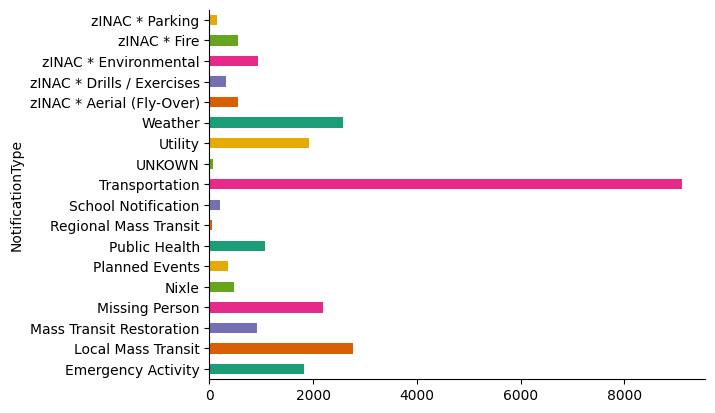

In [138]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('NotificationType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [139]:
df_1 = df.drop(columns = ['Record ID','Date and Time','Notification Title','Email Body']).astype(str)
df_1.head()

,NotificationType,all_text
0,zINAC * Aerial (Fly-Over),This is a message from Notify NYC. Notificatio...
1,zINAC * Drills / Exercises,This is a message from Notify NYC. Notificatio...
2,zINAC * Drills / Exercises,This is a message from Notify NYC. Notificatio...
3,zINAC * Drills / Exercises,This is a message from Notify NYC. Notificatio...
4,zINAC * Aerial (Fly-Over),This is a message from Notify NYC. Notificatio...


In [140]:
porter = PorterStemmer()
corpus = []
for i in range(0,len(df_1)):
    review = re.sub('[^a-zA-Z]',' ',df_1['all_text'][i])
    review = review.lower()
    review = review.split()
    review = [porter.stem(word) for word in review if not word in stopwords.words('english')]
    review = " ".join(review)
    corpus.append(review)

In [156]:
review[:100]

'notif issu pm due person struck train long island rail road port washington branch servic suspend di'

In [141]:
# CountVectorizer
cv = CountVectorizer(max_features=4000,ngram_range=(1,4))
X = cv.fit_transform(corpus).toarray()
# cv.get_feature_names()[:20]

In [142]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 4000,
 'min_df': 1,
 'ngram_range': (1, 4),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

### Data Training, Labeling And Splitting

In [143]:
from sklearn import preprocessing

In [144]:
le = preprocessing.LabelEncoder()
df['NotificationType'] = le.fit_transform(df['NotificationType'])
y = df['NotificationType']

In [145]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [146]:
type(y_test.values)

numpy.ndarray

In [148]:
print(le.classes_)

['Emergency Activity' 'Local Mass Transit' 'Mass Transit Restoration'
 'Missing Person' 'Nixle' 'Planned Events' 'Public Health'
 'Regional Mass Transit' 'School Notification' 'Transportation' 'UNKOWN'
 'Utility' 'Weather' 'zINAC * Aerial (Fly-Over)'
 'zINAC * Drills / Exercises' 'zINAC * Environmental' 'zINAC * Fire'
 'zINAC * Parking']


### Implementation Of Model

In [150]:
from sklearn.tree import DecisionTreeClassifier
import sklearn
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
cm = confusion_matrix(y_test, dtree_predictions)
print(sklearn.metrics.classification_report(y_test, dtree_predictions, labels=range(len(le.classes_))))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       557
           1       0.88      0.42      0.57       984
           2       0.00      0.00      0.00       283
           3       1.00      0.92      0.96       703
           4       0.00      0.00      0.00       136
           5       0.00      0.00      0.00       121
           6       0.00      0.00      0.00       369
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00        69
           9       0.39      0.98      0.56      2999
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00       638
          12       0.00      0.00      0.00       865
          13       0.00      0.00      0.00       197
          14       0.00      0.00      0.00        97
          15       0.00      0.00      0.00       309
          16       0.00      0.00      0.00       183
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [151]:
# training a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)

# accuracy on X_test
accuracy = gnb.score(X_test, y_test)
print(accuracy)

# creating a confusion matrix
cm = confusion_matrix(y_test, gnb_predictions)
print(sklearn.metrics.classification_report(y_test, gnb_predictions, labels=range(len(le.classes_))))

0.839655573656039
              precision    recall  f1-score   support

           0       0.53      0.51      0.52       557
           1       0.78      0.73      0.76       984
           2       0.52      0.90      0.66       283
           3       1.00      1.00      1.00       703
           4       0.73      0.81      0.77       136
           5       0.22      0.35      0.27       121
           6       0.89      0.70      0.79       369
           7       0.23      0.50      0.31        20
           8       0.93      0.80      0.86        69
           9       0.97      0.87      0.92      2999
          10       0.16      0.23      0.19        22
          11       0.93      0.94      0.94       638
          12       0.96      0.97      0.96       865
          13       0.79      0.87      0.83       197
          14       0.63      0.74      0.68        97
          15       0.82      1.00      0.90       309
          16       0.63      0.85      0.72       183
         

In [152]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)

# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print(accuracy)

# creating a confusion matrix
knn_predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, knn_predictions)

print(sklearn.metrics.classification_report(y_test, knn_predictions, labels=range(len(le.classes_))))

0.9053991156620899
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       557
           1       0.89      0.89      0.89       984
           2       0.73      0.87      0.79       283
           3       0.99      1.00      1.00       703
           4       0.57      0.89      0.70       136
           5       0.64      0.48      0.55       121
           6       0.83      0.90      0.86       369
           7       0.67      0.10      0.17        20
           8       0.94      0.87      0.90        69
           9       0.95      0.94      0.95      2999
          10       0.25      0.18      0.21        22
          11       0.98      0.92      0.95       638
          12       0.99      0.96      0.97       865
          13       0.84      0.86      0.85       197
          14       0.89      0.81      0.85        97
          15       0.99      0.99      0.99       309
          16       0.68      0.74      0.70       183
        

In [157]:
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)

# model accuracy for X_test
accuracy = svm_model_linear.score(X_test, y_test)

# creating a confusion matrix
cm = confusion_matrix(y_test, svm_predictions)
print(sklearn.metrics.classification_report(y_test, svm_predictions, labels=range(len(le.classes_))))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       557
           1       0.91      0.87      0.89       984
           2       0.74      0.91      0.82       283
           3       1.00      1.00      1.00       703
           4       0.77      0.91      0.84       136
           5       0.69      0.58      0.63       121
           6       0.92      0.89      0.91       369
           7       0.38      0.25      0.30        20
           8       0.99      0.96      0.97        69
           9       0.96      0.94      0.95      2999
          10       0.45      0.41      0.43        22
          11       0.97      0.97      0.97       638
          12       0.98      0.96      0.97       865
          13       0.86      0.94      0.90       197
          14       0.94      0.82      0.88        97
          15       0.97      1.00      0.98       309
          16       0.77      0.82      0.80       183
          17       0.74    

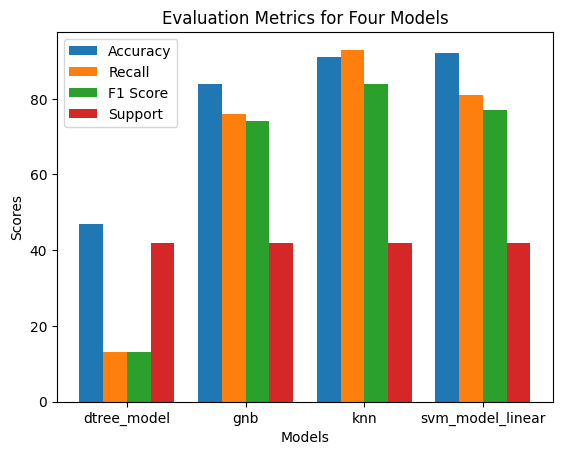

In [6]:
import numpy as np
# Assuming you have evaluation metrics for each model, replace these values with your actual metrics
models = ['dtree_model', 'gnb', 'knn', 'svm_model_linear']
accuracy = [47, 84, 91, 92  ]  # Replace with your accuracy values
recall = [13, 76, 93, 81]  # Replace with your recall values
f1_score = [13, 74, 84, 77]  # Replace with your F1 score values
support = [42, 42, 42, 42]  # Replace with your support values

# Set up the bar chart
bar_width = 0.2
index = np.arange(len(models))

# Plotting accuracy
plt.bar(index, accuracy, width=bar_width, label='Accuracy')

# Plotting recall
plt.bar(index + bar_width, recall, width=bar_width, label='Recall')

# Plotting F1 score
plt.bar(index + 2 * bar_width, f1_score, width=bar_width, label='F1 Score')

# Plotting support
plt.bar(index + 3 * bar_width, support, width=bar_width, label='Support')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Evaluation Metrics for Four Models')
plt.xticks(index + 1.5 * bar_width, models)
plt.legend()

# Show the plot
plt.show()
